## Business Problem

### Business situation

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### Business Understanding & Solution planning

- Motivation: Sales forecasting was requested by CFO on monthly meeting to all sales managers
- Main stakeholder: CFO
- Root cause: In order to evaluate solution, talking to CFO he has made clear that wants to define the budget investiment to refurbish all stores and sales forecast will support it => in this case, the sales forecast it's a suitable solution
- Solution format: 
 - Granularity: information by store by day for the next 6 weeks
 - Problem type: sales forecast
 - Potential methods: time series, regression
 - Deliverables: Will constructed a dashboard to 
   -Total sales forecasted by store for next 6 weeks
   -Sales evolution for next 6 weeks by store


- SAPE:
- Saída (produto final)
 - Resposta para pergunta:
 - Formato Entrega:
 - Local:
- Processo (passo a passo)
 - Coletar os dados das vendas das lojas
 - Avaliar qualidade dos dados

- Entrada:
 - Python 3.9
 - Jupyter Nb
 - Kaggle data
 - 

### Data fields

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 0 Imports

In [265]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

### 0.1 Helper Functions

In [266]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
#jupyter_settings()

### 0.2 Loading Data

In [268]:
df_store_raw = pd.read_csv('datasets/store.csv',low_memory=False)
df_sales_raw = pd.read_csv('datasets/train.csv',low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw,df_store_raw,on='Store',how='left')

## 1. Data description

In [269]:
df = df_raw.copy()

### 1.1 Rename Columns

In [270]:
#transform to snake_case
cols_old = df.columns

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case,cols_old))
df.columns = cols_new

### 1.2 Data dimension

In [271]:
print("Dataset has {} rows".format(df.shape[0]))
print("Dataset has {} attributes".format(df.shape[1]))

Dataset has 1017209 rows
Dataset has 18 attributes


### 1.3 Data types

In [272]:
df.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [273]:
df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")

### 1.4 Dealing with missing values

First of all, it's important to understand why those values are missing. Afterwards, we can decide how to handle these missing values, mainly through: dropping rows/columns (depending on the volume, we can loose a lot of data and it's not recommended), inputing values with a few techniques such as inputting statistics (means, medians, mode), inputing values using assumptions through business thinking (it can lead to ML models underperforming), inputing values using ML techniques. 

In [274]:
df.isna().sum()/df.shape[0]

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

In [275]:
#CompetitionDistance - distance in meters to the nearest competitor store
# ** Assumption ** => If missing, replace for double max value in dataset
#df['competition_distance'].max() * 2 #max distance = 151720

df['competition_distance'] = df['competition_distance'].apply(lambda x: 150000 if pd.isna(x) else x)

In [276]:
#CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
# **Assumption** => we will copy sale date to competetition open since month/year

df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month'])
                                                                                   else x['competition_open_since_month'],axis=1)

df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year'])
                                                                                   else x['competition_open_since_year'],axis=1)

In [277]:
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
df['promo2_since_week'] = df.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

df['promo2_since_year'] = df.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'],axis=1)



In [278]:
#PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

df['promo_interval'].fillna(0, inplace=True)

#translates month (in numbers) to month (in string) and check in a new attribute if sale was in active promo

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['month_map'] = df['date'].dt.month.map(month_map)
df['is_promo'] = df[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [279]:
df.isna().sum()/df.shape[0]

store                           0.0
day_of_week                     0.0
date                            0.0
sales                           0.0
customers                       0.0
open                            0.0
promo                           0.0
state_holiday                   0.0
school_holiday                  0.0
store_type                      0.0
assortment                      0.0
competition_distance            0.0
competition_open_since_month    0.0
competition_open_since_year     0.0
promo2                          0.0
promo2_since_week               0.0
promo2_since_year               0.0
promo_interval                  0.0
month_map                       0.0
is_promo                        0.0
dtype: float64

### 1.5 Change Types

In [280]:
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [281]:
df['competition_open_since_month'] = df['competition_open_since_month'].astype('int64')
df['competition_open_since_year'] = df['competition_open_since_year'].astype('int64')

df['promo2_since_week'] = df['promo2_since_week'].astype('int64')
df['promo2_since_year'] = df['promo2_since_year'].astype('int64')

In [282]:
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.6 Descriptive statistics

In [283]:
num_attr = df.select_dtypes(include=['int64','float64'])
cat_attr = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [284]:
num_att_metrics = num_attr.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

In [285]:
num_att_metrics

,features,mean,median,std,min,max,skew,kurtosis
0,store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
7,competition_distance,5805.577526,2330.0,10654.365263,20.0,150000.0,7.492361,88.374150
8,competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


#### 1.7.2 Categorical Attributes

In [286]:
cat_attr.agg(['count','unique']).T

,count,unique
state_holiday,1017209,"[0, a, b, c]"
store_type,1017209,"[c, a, d, b]"
assortment,1017209,"[a, c, b]"
promo_interval,1017209,"[0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,..."
month_map,1017209,"[Jul, Jun, May, Apr, Mar, Feb, Jan, Dec, Nov, ..."


## 2.0 Feature Engineering

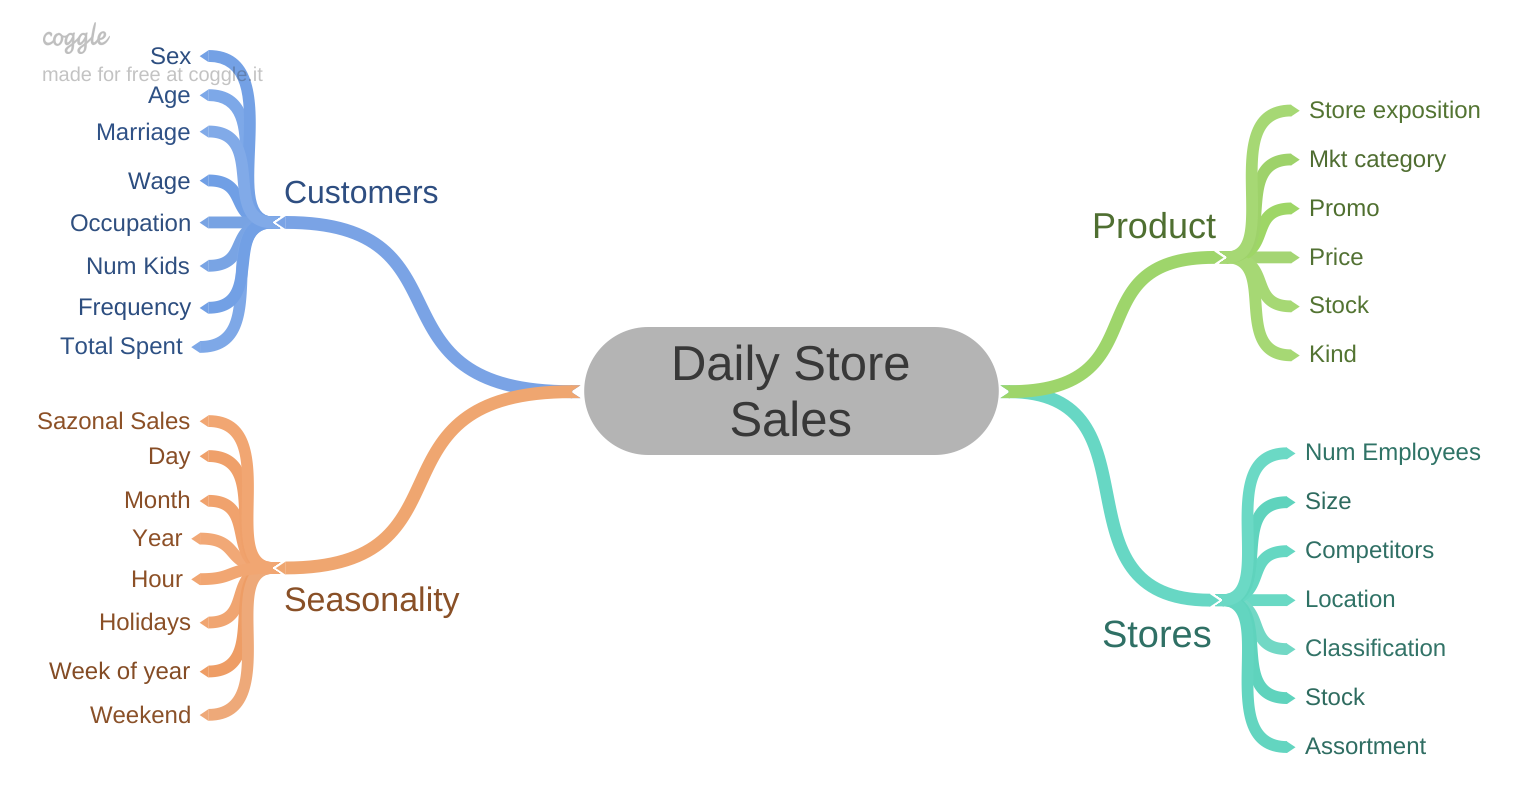

In [287]:
Image('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann\\rossmann_sales_prediction\\img\\MindMapHyp.png',width = 800, height = 400)

### 2.1 Hypothesis brainstorming

#### 2.1.1 Hypothesis Stores

**1.** Stores with bigger staff are supposed to sell more 

**2.** Stores with bigger stocks are supposed too sell more 

**3.** Bigger stores are supposed too sell more

**4.** Stores with wider items assortment are supposed too sell more

**5.** Stores with nearer competitors are supposed too sell less

**6.** Stores with longer competition are supposed too sell more

#### 2.1.2 Hypotheis Products

**1.** Stores with products with more ads investment are supposed to sell more

**2.** Stores with products better exposed are supposed to sell more

**3.** Stores with lower products are supposed to sell more

**5.** Stores with agressive products promotions are supposed to sell more

**6.** Stores with longer products sales are supposed to sell more 

**7.** Stores with products under consecutives sales are supposed to sell more 

#### 2.1.3 Hypotheis Seasonality

**1.** Stores opened during Christmas Holiday are supposed to sell more.

**2.** Stores are supposed to sell more past the first years

**3.** Stores are supposed to sell more on 2nd semester 

**4.** Stores are supposed to sell more after 10th day on the month

**5.** Stores are supposed to sell less in the weekend 

**6.** Stores are supposed to sell less during scholar holidays 

### 2.2 Prioritized Hypothesis (are there data in this crisp cycle to evaluate it?)

**1.** Stores with wider items assortment are supposed too sell more

**2.** Stores with nearer competitors are supposed too sell less

**3.** Stores with longer competition are supposed too sell more

**4.** Stores with longer products sales are supposed to sell more 

**5.** Stores with products under consecutives sales are supposed to sell more 

**6.** Stores opened during Christmas Holiday are supposed to sell more.

**7.** Stores are supposed to sell more past the first years

**8.** Stores are supposed to sell more on 2nd semester 

**9.** Stores are supposed to sell more after 10th day on the month

**10.** Stores are supposed to sell less in the weekend 

**11.** Stores are supposed to sell less during scholar holidays 


In [288]:
df2 = df.copy()

### 2.3 Feature Engineering

In [289]:
#creating date features
#year
df2['year'] = df2['date'].dt.year

#day
df2['day'] = df2['date'].dt.day

#month
df2['month'] = df2['date'].dt.month

#week_of_year
df2['week_of_year'] = df2['date'].dt.weekofyear

#week-year
df2['year_week'] = df2['date'].dt.strftime("%Y-%W")

C:\Users\marco\AppData\Local\Temp\ipykernel_9364\3884551600.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [290]:
#competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

In [291]:
#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

In [292]:
#assortment => assortment level: a = basic, b = extra, c = extended
#df2['assortment'].unique()
df2['assortment'] = df2['assortment'].map({'a':'basic', 'b':'extra','c':'extended'})

In [293]:
#state_holday => a = public holiday, b = Easter holiday, c = Christmas, 0 = None
#df2['state_holiday'].unique()
df2['state_holiday'] = df2['state_holiday'].map({'a':'public', 'b':'easter','c':'christmas','0':'regular'})

## 3.0 Feature Filtering

In [294]:
#Feature Filtering => according to business constraints and data
#Feature Selection => most relevant feature to modeling
df3 = df2.copy()

### 3.1 Rows filtering

In [295]:
#open == 0 means store closed and we cant predict any sales
#sales == 0 means store didnt sell anything and we cant predict any sales
df3 = df3[(df3['open'] != 0) | (df3['sales'] > 0)].reset_index(drop=True)

### 3.2 Attributes filtering

In [296]:
#customers is an attribute that must be predicted first (from another model) and used as input to predict sales (we dont have this prediction)
#open remained only open == 1, it's meaningless attribute
#promo_interval and month_map were manipulated onto new attributes
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop,axis=1)